# Analyze 10 classes of ImageNet

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
savepath = "dataset/precomputed/imagenette"

In [2]:
all_class_colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1)]

label_to_name = {0: 'tench',
 1: 'English_springer',
 2: 'cassette_player',
 3: 'chain_saw',
 4: 'church',
 5: 'French_horn',
 6: 'garbage_truck',
 7: 'gas_pump',
 8: 'golf_ball',
 9: 'parachute'}

## Load precomputed graph and lens

In [3]:
labels = np.load(f"{savepath}/labels.npy")
with open(f"{savepath}/train_nodes.txt","r") as f:
    lines = f.readlines()
    train_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/val_nodes.txt","r") as f:
    lines = f.readlines()
    val_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/test_nodes.txt","r") as f:
    lines = f.readlines()
    test_nodes = [int(i.strip()) for i in lines]
ei,ej,e = [],[],[]
with open(f"{savepath}/edge_list.txt","r") as f:
    lines = f.readlines()
    num_nodes = int(lines[0].strip().split(' ')[0])
    for line in lines[1::]:
        line = line.strip().split(' ')
        ei.append(int(line[0]))
        ej.append(int(line[1]))
        e.append(int(line[2]))
G = sp.csr_matrix((e,(ei,ej)),(num_nodes,num_nodes))
preds = np.load(f"{savepath}/prediction_lens.npy")
pred_labels = np.argmax(preds,1)

## Compute Reeb graph and estimated errors

In [4]:
from GTDA.GTDA_utils import compute_reeb, NN_model
from GTDA.GTDA import GTDA

nn_model = NN_model()
nn_model.preds = preds
nn_model.labels = labels
nn_model.A = G
nn_model.train_mask = np.zeros(G.shape[0])
nn_model.train_mask[train_nodes] = 1
nn_model.val_mask = np.zeros(G.shape[0])
nn_model.val_mask[val_nodes] = 1
nn_model.test_mask = np.zeros(G.shape[0])
nn_model.test_mask[test_nodes] = 1
smallest_component = 25
overlap = 0.01
labels_to_eval = list(range(preds.shape[1]))
GTDA_record = compute_reeb(GTDA,nn_model,labels_to_eval,smallest_component,overlap,extra_lens=None,
    node_size_thd=5,reeb_component_thd=5,nprocs=10,device='cuda',split_thd=0.001,nsteps_preprocess=10)

Preprocess lens..
Merge reeb nodes...
Build reeb graph...
Total time for building reeb graph is 6.237902402877808 seconds
Compute mixing rate for each sample


In [5]:
from GTDA.GTDA_utils import save_to_json
save_to_json(GTDA_record, nn_model, savepath, label_to_name)

## Visualize a component of GTDA results

100%|██████████| 72/72 [00:00<00:00, 577.11it/s]


Text(0.5, 1.0, 'estimated errors')

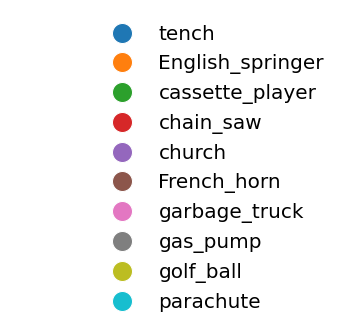

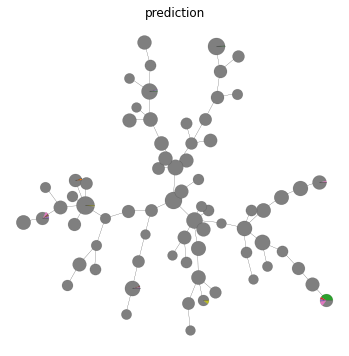

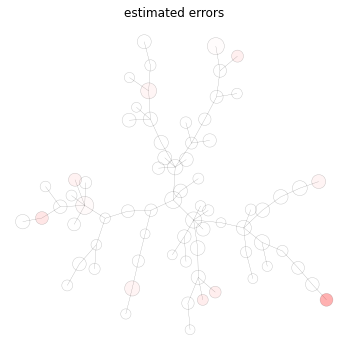

In [6]:
import networkx as nx
from GTDA.GTDA_utils import find_components, plot_reeb_component
import pandas as pd
from matplotlib.lines import Line2D

gtda = GTDA_record['gtda']
g_reeb = GTDA_record['g_reeb']
reeb_components = find_components(g_reeb,size_thd=0)[1]
component_index = 6
component = reeb_components[component_index]
g_sub = g_reeb[component,:][:,component]
xcoords = np.zeros(len(component))
ycoords = np.zeros(len(component))
pos_tmp = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(g_sub))
for i in range(len(component)):
    xcoords[i] = pos_tmp[i][0]
    ycoords[i] = pos_tmp[i][1]
df = pd.DataFrame({'x':xcoords,'y':ycoords,'sizes':40*gtda.node_sizes[gtda.filtered_nodes[component]]**0.5})

patches = []
for label_to_eval in labels_to_eval:
    patches.append(
        Line2D(
            [0],[0],marker='o',markerfacecolor=all_class_colors[label_to_eval],
            label=f"{label_to_name[label_to_eval]}",color='w',markersize=20))
fig_legend,ax_legend = plt.subplots(figsize=(6, 1))
ax_legend.legend(handles=patches,fontsize=20,framealpha=0,ncol=1)
ax_legend.axis('off')

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_reeb_component(g_sub,df,gtda.node_colors_class[gtda.filtered_nodes[component]],
    labels_to_eval=labels_to_eval,all_class_colors=all_class_colors,fig=fig,ax=ax)
ax.set_title('prediction')

fig,ax = plt.subplots(figsize=(6,6))
node_colors = [(1,0,0,i) for i in gtda.node_colors_mixing[gtda.filtered_nodes[component]]]
fig,ax = plot_reeb_component(g_sub,df,node_colors,
    labels_to_eval=labels_to_eval,all_class_colors=all_class_colors,fig=fig,ax=ax,is_plotting_error=True)
ax.set_title('estimated errors')

# Embed images on this component

In [7]:
from tqdm import tqdm

with open(f"{savepath}/imgs_list.txt","r") as f:
    lines = f.readlines()
    imgs_list = [i.strip() for i in lines]

nodes = []
for reeb_node in component:
    nodes += gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]
nodes_map = {node:i for i,node in enumerate(nodes)}


A_reeb = nx.from_scipy_sparse_matrix(gtda.A_reeb[nodes,:][:,nodes])
degs = np.sum(gtda.A_reeb,0).A[0][nodes]
path_lengths = dict(nx.shortest_path_length(A_reeb))
shortest_dists = {}
g_reeb_sub = g_reeb.tocsr()[component,:][:,component]
for i in tqdm(range(g_reeb_sub.shape[0])):
    ci = np.array(gtda.final_components_filtered[gtda.filtered_nodes[component[i]]])
    for j in g_reeb_sub[i].indices:
        cj = gtda.final_components_filtered[gtda.filtered_nodes[component[j]]]
        ci_dists = []
        for curr_i in ci:
            curr_i = nodes_map[curr_i]
            curr_dist = float('inf')
            for curr_j in cj: 
                curr_j = nodes_map[curr_j]
                curr_dist = min(curr_dist,path_lengths[curr_i][curr_j])
            ci_dists.append((curr_dist,-1*degs[i]))
        ci_dists = np.array(ci_dists, dtype=[('x', '<i4'), ('y', '<i4')])
        shortest_dists[(i,j)] = ci[np.argsort(ci_dists,order=('x','y'))]

100%|██████████| 72/72 [00:00<00:00, 656.47it/s]


(-1.12, 1.0798296844614899, -0.7978536850428187, 0.9542729335793254)

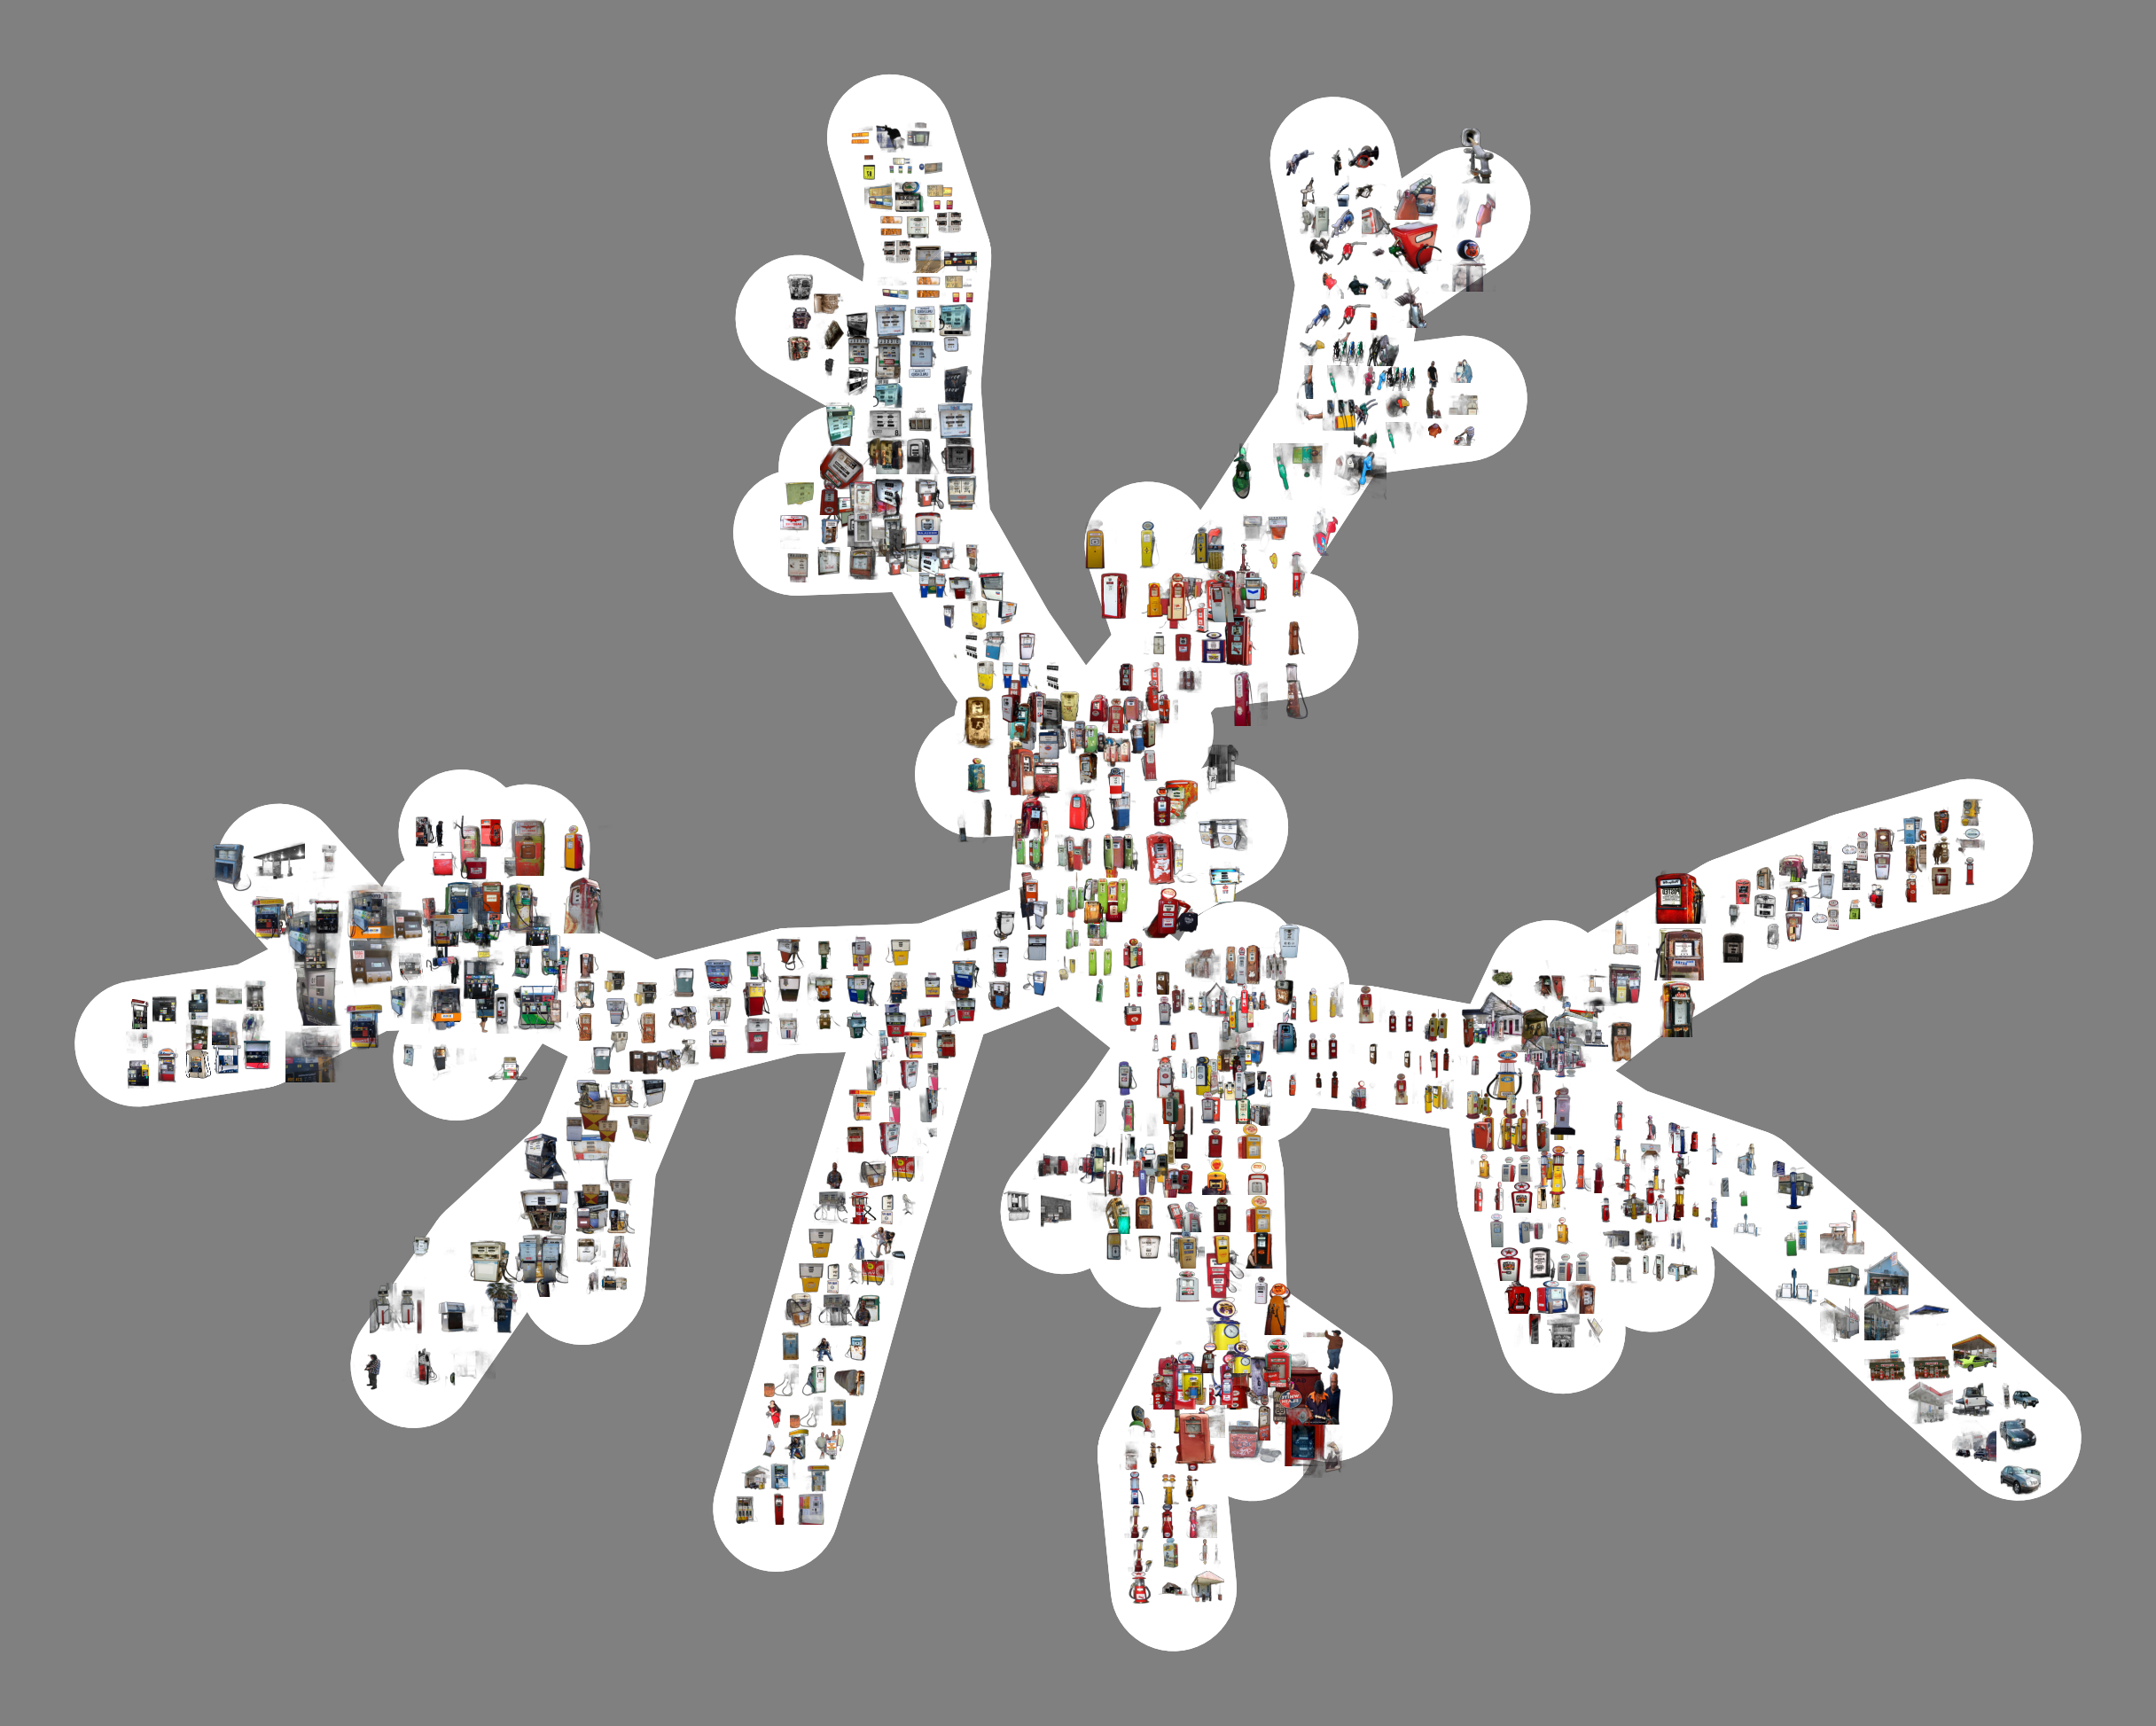

In [7]:
from collections import defaultdict
from GTDA.GTDA_utils import align_images, remove_img_bg
from PIL import Image


coords = np.vstack([xcoords,ycoords])
scale = 0.06
fig,ax = plt.subplots(figsize=(12,12),dpi=256,facecolor='grey')
neighs = defaultdict(list)
all_images_embeded = {}
g_reeb_sub = g_reeb_sub.tocoo()
for i,j in zip(g_reeb_sub.row,g_reeb_sub.col):
    neighs[i].append(j)
for i in range(len(component))[::-1]:
    start_pos = coords[:,i]
    for k,neigh in enumerate(neighs[i]):
        end_pos = (start_pos+coords[:,neigh])/2
        images = [remove_img_bg(Image.open(imgs_list[i])) for i in shortest_dists[(i,neigh)]]
        num_images_embeded = align_images(
            start_pos,end_pos,scale,images,ax,3,k==0,flipped=True)
        all_images_embeded[(i,neigh)] = shortest_dists[(i,neigh)][0:num_images_embeded]

for ei,ej in zip(g_reeb_sub.row,g_reeb_sub.col):
    ax.plot(
        [coords[0][ei],coords[0][ej]],[coords[1][ei],coords[1][ej]],c='white',
        lw=40,zorder=-1,solid_capstyle='round',alpha=1)
ax.set_xlim((np.min(coords[0])-scale*2,np.max(coords[0])+scale*2))
ax.set_ylim((np.min(coords[1])-scale*2,np.max(coords[1])+scale*2))
ax.axis('off')